# Building a RAG-Powered Customer Support Assistant

This notebook demonstrates how to build a simple customer support system using the Retrieval Augmented Generation (RAG) approach with LangChain and an appropriate language model.

This is a common use case for companies wanting to build customer support system that can provide accurate, contextualized responses about their products based on official documents and policies.

#### Why LangChain?

LangChain is an ideal framework for building applications because:

1. **Component Integration**: LangChain provides ready-to-use components for each step of the pipeline, from document loading and text splitting to embedding and retrieval.

2. **Modular Architecture**: Its modular design allows us to easily swap components (e.g., switch embedding models or vector stores) without changing the overall application structure.

3. **Abstraction Layer**: LangChain abstracts away the complexity of integrating different tools and services, providing a consistent interface regardless of the underlying implementations.

4. **LangGraph Support**: The companion LangGraph library enables flexible orchestration of the workflow, allowing for more complex retrieval and reasoning patterns.

#### LLM Options

For this notebook, let's go with open-source models that offer excellent performance for RAG applications:

1. **Mistral Models**: Models like mistral-small-latest is a powerful free model with 131k token context window that provide strong reasoning capabilities suitable for RAG applications.

2. **Other options** (if needed):
   - `Llama 3 models`: Meta's Llama 3 models also demonstrate excellent context understanding and response generation.
   - `Gemma models`: Google's Gemma models also offer good performance with smaller model sizes.

#### RAG vs. Standard AI Chatbots

A standard AI chatbot relies solely on pre-trained knowledge, which has several limitations:
- Knowledge cutoff dates mean information may be outdated
- No access to proprietary or specialized information
- Lack of citations or sources for claims
- Higher tendency to hallucinate when uncertain

In contrast, RAG-enhanced chatbots:
- Retrieve fresh, relevant information from your knowledge base in real-time
- Can answer questions about proprietary information not in training data
- Provide sources and citations for their responses
- Ground answers in specific documents, reducing inaccuracies

## 1. Overview of the Architecture

It will consists of two main phases:
1. **Indexing Phase** (done offline):
   - Loading documents
   - Splitting documents into chunks
   - Embedding and storing chunks in a vector database

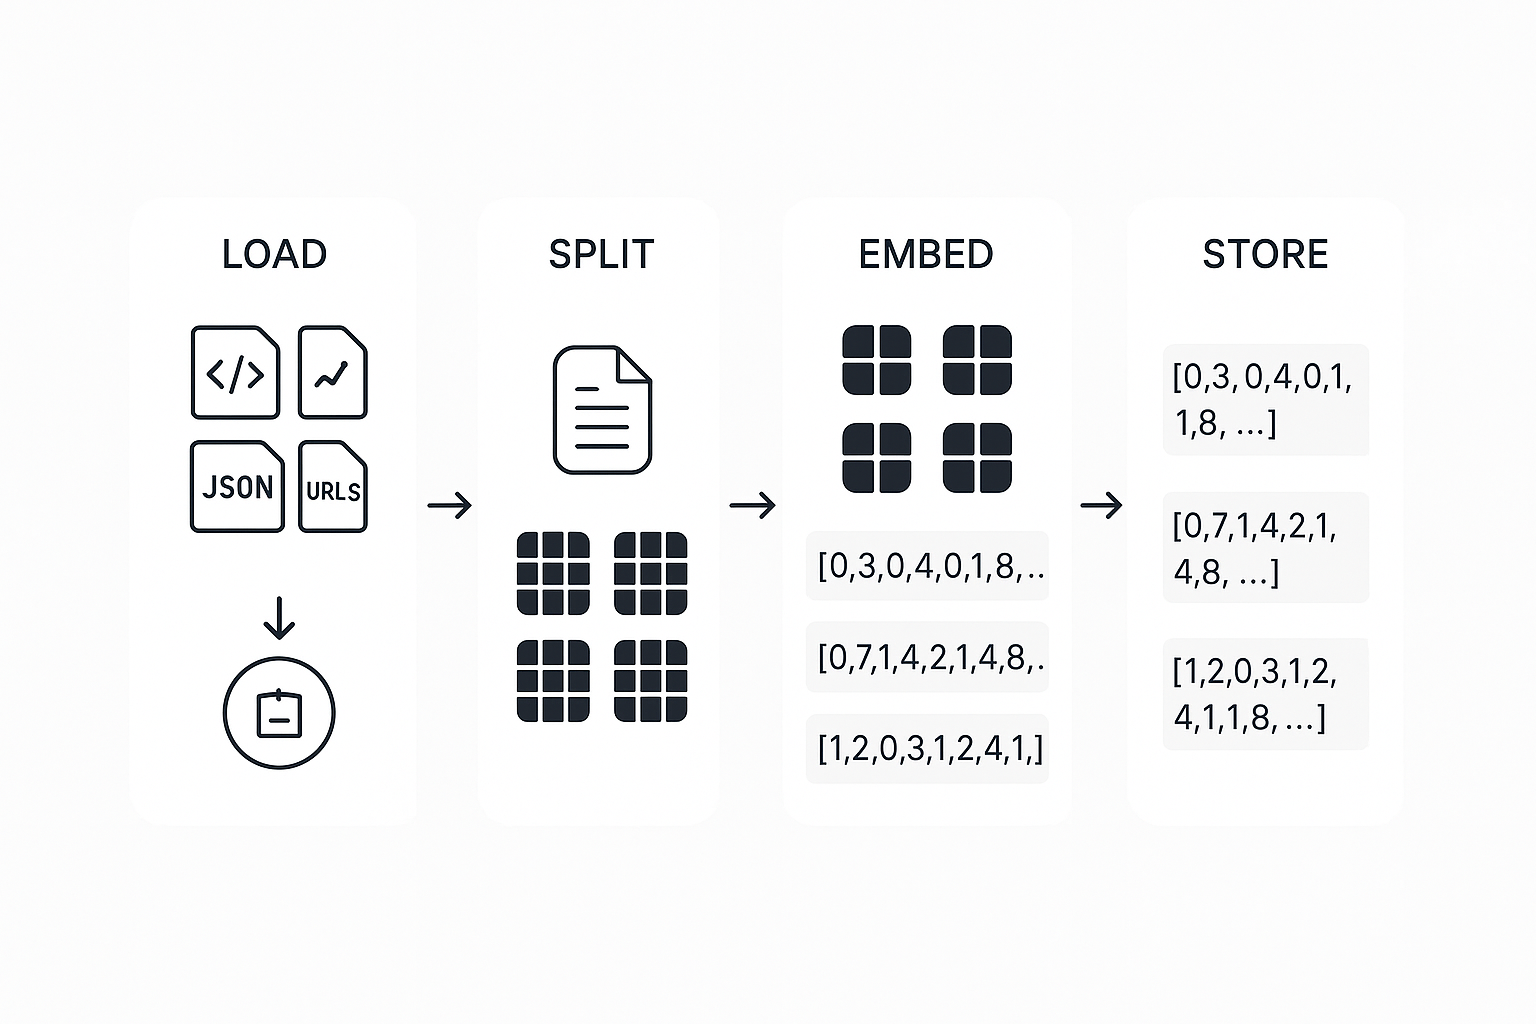
2. **Query Phase** (at runtime):
   - Retrieve relevant document chunks based on the query
   - Use an LLM to generate an answer using the retrieved context
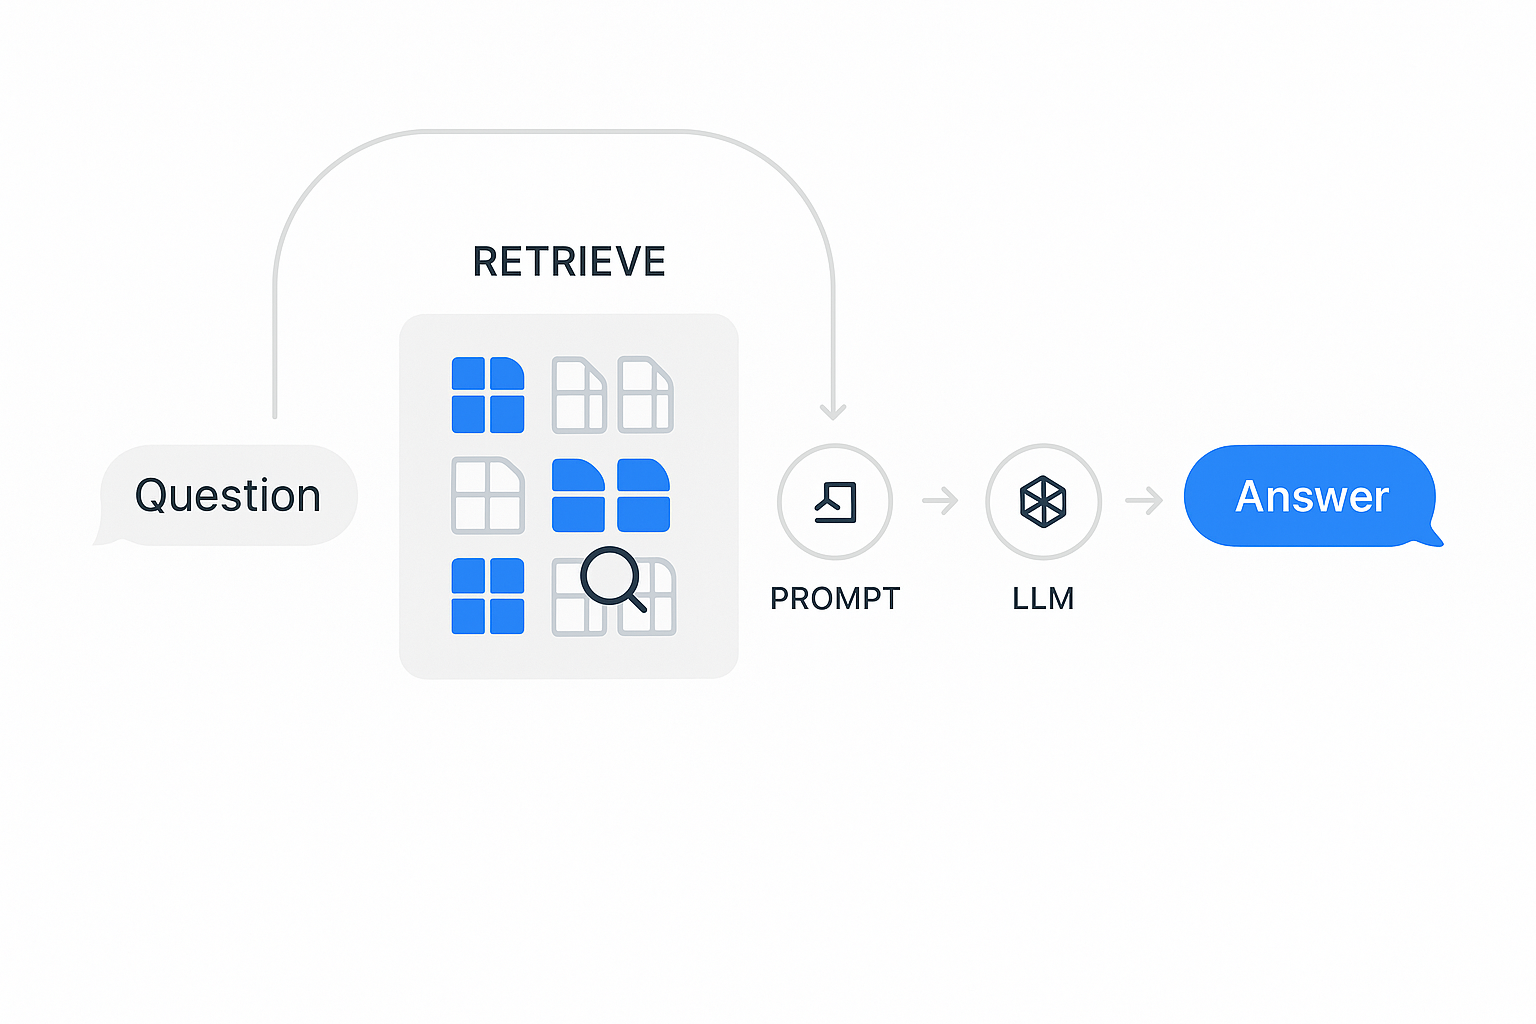

## 2. Installing Dependencies

In [1]:
!pip install --quiet langchain-text-splitters langchain-community langgraph
!pip install --quiet chromadb sentence-transformers
!pip install --quiet langchain-mistralai
!pip install --quiet gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.0/19.0 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 7.3 MB/s eta 0:00:0

## 3. Importing Libraries

In [2]:
import os
import json
import time
import gradio as gr
from langchain import hub
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_core.prompts import PromptTemplate
from typing_extensions import TypedDict, List
from langgraph.graph import START, StateGraph

# Import Mistral API integration
from langchain_mistralai import ChatMistralAI

#### Access API Key Stored in Colab's Secrets
Working in Colab environment, one of the safest way to access API keys is through Colab-specific module (`google.colab.userdata`) but also wrapping it in `try/except` to ensure that the code doesn't break when it's run outside of Colab, such as in a local Jupyter notebook or another cloud environment.

In case of other environments, it checks for an environment variable or manual entry to make the notebook cross-platform compatible.

In [3]:
try:
    from google.colab import userdata
except ImportError:
    userdata = None

# Access the secret
if userdata:
    api_key = userdata.get('MISTRAL_API_KEY')
else:
    # Fall back to environment variable or manual entry
    api_key = os.getenv("MY_API_KEY") or input("Enter your API key: ")

print("API key loaded successfully")

API key loaded successfully


## 4. Indexing Phase

#### 4.1 Loading Document
LangChain's Document concept is like a smart container for text. It holds both the text itself and helpful information about that text (like where it came from or what topic it covers).

And LangChain's DocumentLoaders is a special tool that can pull information from almost anywhere - PDFs, websites, spreadsheets, and more. They automatically convert this information into LangChain's standard Document format that your AI application can understand and use.

This makes it much easier to build AI applications that can work with information from many different sources without having to write special code for each type of document.

In this case, let's load a sample customer support knowledge base template from a JSON file. It contains frequently asked questions and answers organized by category.

In [4]:
# Check that the file exists before trying to load it
if not os.path.exists('knowledge_base.json'):
    raise FileNotFoundError("The knowledge_base.json file is missing. Please upload it or check the path.")

# Load the knowledge base from file
with open('knowledge_base.json', 'r') as file:
    kb_data = json.load(file)

In [5]:
# Convert the knowledge base into a list of documents
documents = []

# Process each category and question
for category in kb_data['knowledge_base']:
    category_name = category['category']

    for qa_pair in category['questions']:
        question = qa_pair['question']
        answer = qa_pair['answer']

        # Create a document with the question and answer
        content = f"Question: {question}\nAnswer: {answer}"

        # Store as a Document object with metadata
        doc = Document(
            page_content=content,
            metadata={
                "category": category_name,
                "question": question,
                "source": "knowledge_base.json"
            }
        )

        documents.append(doc)

In [6]:
print(f"Loaded {len(documents)} documents from knowledge base")
print(f"Categories: {set(doc.metadata['category'] for doc in documents)}")
print("\nSample document:")
print(f"Category: {documents[0].metadata['category']}")
print(f"Content: {documents[0].page_content[:200]}...")

Loaded 71 documents from knowledge base
Categories: {'ORDERS, SHIPPING & DELIVERY', 'MEMBERSHIP & ACCOUNT', 'RETURNS', 'PAYMENT OPTIONS'}

Sample document:
Category: MEMBERSHIP & ACCOUNT
Content: Question: What are the benefits of becoming a Member?
Answer: Being a member has something for you no matter what you want to do. Get guidance from our experts, access to member-only experiences, spec...


This approach transforms our structured sample knowledge base into a format suitable for RAG processing. Each Q&A pair becomes a document with appropriate metadata that will help us with:

1. Filtering results by category
2. Tracing answers back to their source questions
3. Organizing content for better retrieval

#### 4.2 Splitting Document

Document splitting is crucial for effective retrieval and use in downstream applications. Large documents often need to be broken into smaller, more manageable chunks that can fit within the model's context window and allow for more precise retrieval.


There are various methods for splitting documents, each with its own advantages. The recommended text splitter for generic text use cases is `RecursiveCharacterTextSplitter`. It recursively splits the document using common separators like new lines until each chunk is of appropriate size.

In [7]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

# For demonstration purposes, we'll set up a text splitter
# This is more useful for longer documents but included here for completeness
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # Characters per chunk
    chunk_overlap=100,  # Overlap between chunks
    separators=["\n\n", "\n", ". ", " ", ""],  # Try to split on paragraph breaks first
    keep_separator=False
)

The above step sets up a text splitter that could be used for longer documents. Since FAQ documents are already well-structured with individual question-answer pairs, it doesn't actually need to be splitted further. However, the text splitter setup demonstrates how it would work with longer content.

In this case, since the document is relatively short, a simple approach that respects the question-answer format of the data would suffice.

In [8]:
# If we had longer documents, we would use:
# all_splits = text_splitter.split_documents(documents)

# Since the documents are short, we skip splitting and use them as-is
all_splits = documents

In [9]:
print(f"Number of document chunks: {len(all_splits)}")
print(f"Sample chunk: {all_splits[0].page_content[:200]}...")
print(f"Sample chunk metadata: {all_splits[0].metadata}")

Number of document chunks: 71
Sample chunk: Question: What are the benefits of becoming a Member?
Answer: Being a member has something for you no matter what you want to do. Get guidance from our experts, access to member-only experiences, spec...
Sample chunk metadata: {'category': 'MEMBERSHIP & ACCOUNT', 'question': 'What are the benefits of becoming a Member?', 'source': 'knowledge_base.json'}


Some of the proper text splitting strategies include:
- Breaking at natural boundaries (paragraphs, sections)
- Including headers in each chunk for context
- Using appropriate overlap to prevent information loss at chunk boundaries
- Adapting chunk size to the embedding model's token limit

#### 4.3 Embedding and Storing

The final step in the indexing phase is to convert the above text chunks into vector embeddings and store them in a vector database for efficient similarity search.


**Embeddings** are numerical representations of text that capture semantic meaning. When the Q&A pairs are converted into embeddings:

1. Each document becomes a vector of numbers
2. Similar texts have similar vectors (closer in the vector space)
3. This allows for semantic search rather than just keyword matching
4. It enables efficient retrieval of the most relevant documents from the vector store

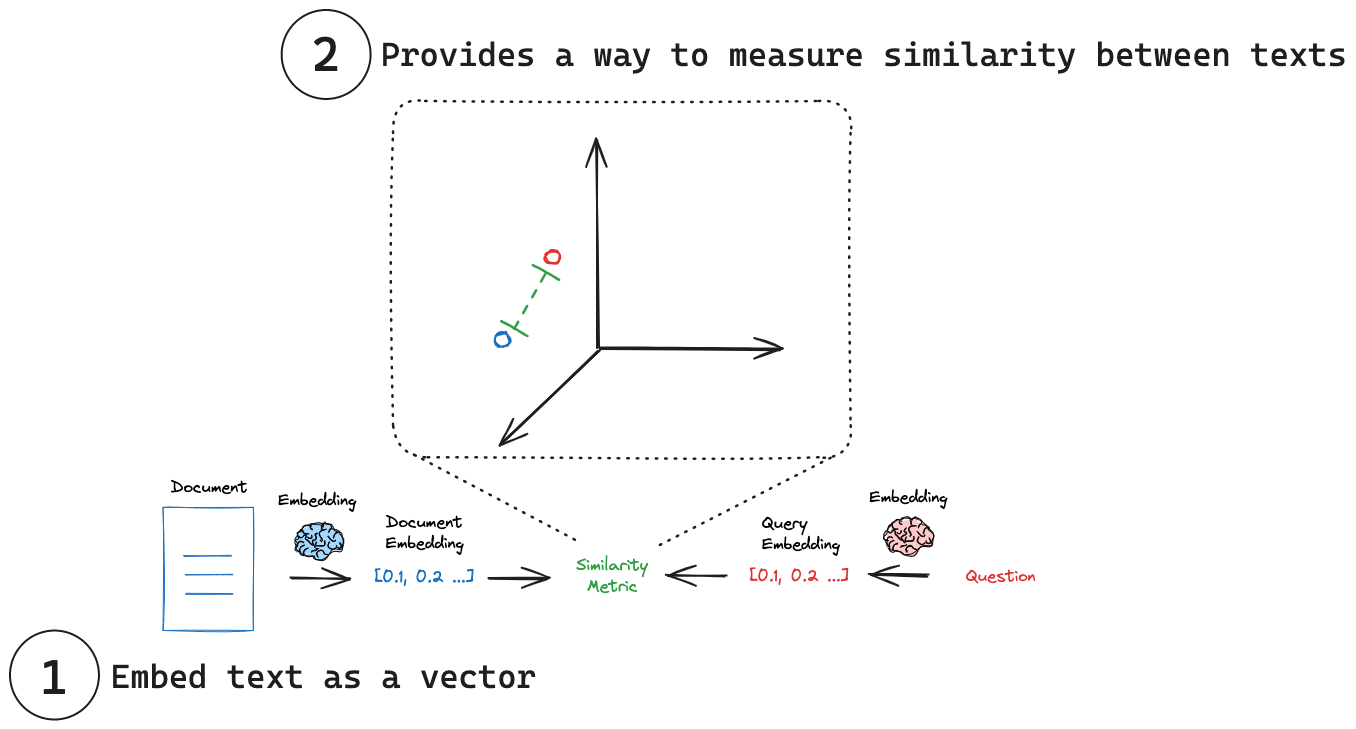
(Image Source: https://python.langchain.com/docs/concepts/embedding_models/)

In this case, let's use a `Sentence Transformers` model from **HuggingFace**. It is a pre-trained model for creating high-quality text embeddings that capture semantic meaning.

In [10]:
# Initialize embedding model (open source)
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
    model_kwargs={'device': 'cpu'}
)

<ipython-input-10-734ccff1375d>:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

**Vector stores** are specialized databases designed to efficiently store and query vector embeddings. Vector store helps with:

1. Indexing the embeddings to enable fast similarity search
2. Maintaining the connection between vectors and their source documents
3. Providing methods to find the most semantically similar documents to a query

The vector store serves as the "memory" of the RAG system, allowing it to quickly locate the most relevant information from the knowledge base when responding to customer queries.

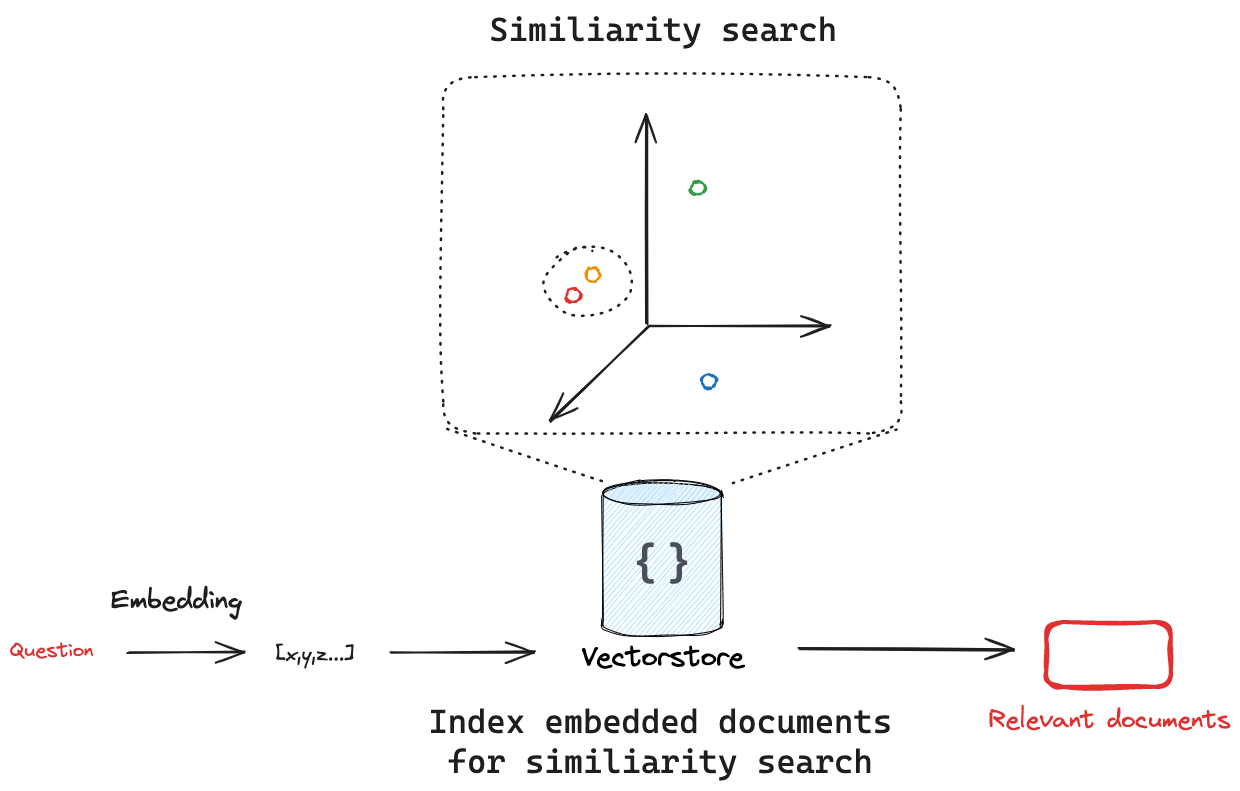
(Image Source: https://python.langchain.com/docs/concepts/vectorstores/)

For this implementation, **Chroma** is used which is a lightweight open-source vector database that's easy to set up and use. It provides a simple integration with LangChain and also supports metadata filtering to narrow search results.

In [11]:
# Create vector store from documents
vector_store = Chroma.from_documents(
    documents=all_splits,
    embedding=embeddings,
    collection_name="customer_support_faq"
)

print("Vector store created successfully!")

Vector store created successfully!


In [12]:
# Test similarity search
test_query = "I forgot my password"
similar_docs = vector_store.similarity_search(test_query, k=1)
print(f"\nTest query: '{test_query}'")
print(f"Found similar document: {similar_docs[0].page_content[:150]}...")
print(f"From category: {similar_docs[0].metadata.get('category', 'unknown')}")


Test query: 'I forgot my password'
Found similar document: Question: How Do I Reset My Member Password?
Answer: To reset your password using our app: 1. Open your app. 2. Tap 'Sign In.' 3. Enter the email addr...
From category: MEMBERSHIP & ACCOUNT


It finds semantically similar content through the following process:

1. When a query is passed, it uses the same embedding model to convert the text query into a vector embedding
2. It then performs a similarity search by comparing this query embedding to all the document embeddings stored in the database
3. The similarity calculation typically uses cosine similarity or similar measures to find which document vectors are "closest" to the query vector
4. It then returns the documents whose embeddings are most similar to the query embedding, ranked by similarity

This semantic approach understands meaning rather than just matching keywords - for example, if searched for "account access problems," it can return relevant documents about password resets, even without exact keyword matches.

Now the knowledge base is indexed and ready for the query phase of RAG.

## 5. Query Phase

After indexing the knowledge base, the next step is to implement the retrieval and generation components of the RAG system.

The components of this RAG pipeline will include:

1. **LLM**: Mistral's small model through their API, which provides a generous context window that allows multiple Q&A pairs to be included in prompts.

2. **Custom Prompt**: A custom prompt template that positions the model as a customer support assistant and provides clear instructions on how to use the retrieved information.

3. **Application State**: The state of the application tracks the question, retrieved context, and generated answer throughout the pipeline.

4. **Retrieval Step**: This function queries the vector store to find the most semantically similar Q&A pairs to the customer's question. The top 3 matches retrieved will provide adequate context.

5. **Generation Step**: This function formats the retrieved content and prompt, then sends it to the LLM to generate a helpful, contextual response.

6. **Orchestration**: LangGraph connects these components into a sequential workflow, from retrieval to generation.

This pipeline will implement the core RAG pattern: retrieve → contextualize → generate.

#### 5.1 Initialize LLM



In [13]:
# Initialize LLM - using Mistral's API with their free small model
llm = ChatMistralAI(
    api_key=api_key,
    model="mistral-small-latest",
    temperature=0.5,  # Controls randomness in the model's responses
    max_tokens=512    # Limits response length to approximately 400-500 words
)

#### 5.2 Custom Prompt
Now let's create a prompt template that guides how the language model should generate responses.

**Prompt templates** creates a clear structure with pre-designed instructions to ensure AI responds appropriately using only factual information. It usually combines:
1. **Role definition** ("You are a helpful customer support assistant...")
2. **Instructions** ("Use the following information...")
3. **Input placeholders** (user's question and retrieved information)

LangChain provides both custom prompt templates and pre-built prompts that can be directly imported.

Let's define a custom prompt and then convert the string template into a LangChain `PromptTemplate` object to make it compatible with LangChain's components.

In [14]:
# Define our custom prompt
custom_prompt_template = """You are a helpful customer support assistant for a retail company.
Use the following retrieved Q&A pairs to answer the customer's question.
If you don't know the answer based on the provided information, politely say so.

Customer Question: {question}

Retrieved Information: {context}

Answer:"""

custom_prompt = PromptTemplate.from_template(custom_prompt_template)

#### 5.3 Application State
Let's create a `State` class that serves as a "container" that passes data between different components of the RAG pipeline.

When using LangGraph for orchestration, this `State` definition tells the graph what data structure to expect and maintain throughout the pipeline's execution.

For this simple application, it contains the user's question as a string, retrieved documents as a list of `Document` objects and generated answer as a string.

In [15]:
# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

#### 5.4 Retrieval Step

In [16]:
# Define retrieval function
def retrieve(state: State):
    """Retrieve relevant documents from vector store"""
    # Get the top 3 most relevant Q&A pairs
    retrieved_docs = vector_store.similarity_search(state["question"], k=3)
    return {"context": retrieved_docs}

#### 5.5 Generation Step

In [17]:
# Define generation function
def generate(state: State):
    """Generate an answer using Mistral's API"""
    # Format the retrieved Q&A pairs as context
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])

    # Format with our custom prompt for Mistral API
    messages = custom_prompt.invoke({"question": state["question"], "context": docs_content})

    # Get response from Mistral API
    response = llm.invoke(messages)

    return {"answer": response.content}

#### 5.6 Orchestration
Now using LangGraph to compile the application into a `graph` object by connecting these different components into a sequential workflow.

In [18]:
# Build and compile the graph
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

Let's test the application with some questions.

In [19]:
def ask_question(question: str):
    """Helper function to ask a question and return the answer along with context."""
    result = graph.invoke({"question": question})

    print(f"Question: {question}\n")
    print(f"Answer: {result['answer']}\n")
    print("Context used:")
    for i, doc in enumerate(result["context"]):
        source_info = f"Document {i+1} (category: {doc.metadata.get('category', 'unknown')})"
        print(f"{source_info}")
        print(f"Original question: {doc.metadata.get('question', 'unknown')}")
        print(f"Content snippet: {doc.page_content[:150]}...\n")

    return result

In [20]:
print("Testing our customer support RAG system with sample questions:\n")
print("-" * 50)
result1 = ask_question("How do I reset my password?")
print("-" * 50)
result2 = ask_question("What payment methods do you accept?")

Testing our customer support RAG system with sample questions:

--------------------------------------------------
Question: How do I reset my password?

Answer: To reset your password, follow these steps:

**Using our app:**
1. Open your app.
2. Tap 'Sign In.'
3. Enter the email address connected to your profile and tap 'Continue.'
4. Tap 'Forgot Password?'
5. We'll email you a one-time verification code—use the code to reset your password.

**Using our website:**
1. Tap the menu in the upper right corner on mobile devices or click 'Sign In' on a computer.
2. Follow the similar steps as the app to reset your password.

If you encounter any issues, you can also try the troubleshooting steps mentioned in the second Q&A pair.

Context used:
Document 1 (category: MEMBERSHIP & ACCOUNT)
Original question: How Do I Reset My Member Password?
Content snippet: Question: How Do I Reset My Member Password?
Answer: To reset your password using our app: 1. Open your app. 2. Tap 'Sign In.' 3. Enter 

## 6. Adding Memory and Multi-Turn Conversation Capabilities
So far, this notebook presents a basic RAG-powered customer support assistant that can answer isolated questions based on the knowledge base. However, in real-world chatbots need to maintain context across multiple interactions to provide a natural conversational experience.

Consider this interaction:

> **User**: "What are the benefits of becoming a Member?"
>
> **Assistant**: "Being a member has something for you no matter what you want to do. Get guidance from our experts, access to member-only experiences, special offers, and free shipping on eligible orders..."
>
> **User**: "How do I sign up?"

The follow-up question "How do I sign up?" implicitly refers to membership. Without memory, the system wouldn't understand what the user wants to sign up for.

This section is about enhancing the customer support assistant with:
1. **Message history tracking** - preserving the conversation context
2. **Knowledge base retrieval** - ensuring all answers are grounded in the official documentation
3. **State persistence** - maintaining conversation state across multiple interactions

#### 6.1 Message History Tracking

The initial implementation represented the state as separate keys for questions, context, and answers. For conversation support, let's switch to a message-based representation that can capture the full history of the interaction using LangGraph's `MessagesState`.

The `MessagesState` provides the structure for representing conversations as a sequence of messages (rather than separate keys for questions, context, and answers). It defines what the state looks like at any given point in time during a conversation turn - essentially a list of messages with their types and content. And it automatically manages appending new messages to the conversation history.

Let's update the implementation to use LangGraph's `MessagesState`:

In [21]:
from langgraph.graph import MessagesState

# Initialize graph with message-based state
graph_builder = StateGraph(MessagesState)

#### 6.2 Knowledge Base Retrieval
In the Initial implementation, the retrieval step was directly integrated into the processing flow. For a customer support assistant, it's critical that all responses are grounded in the official documentation, rather than relying on the LLM's pre-trained knowledge which might be incorrect or outdated for our specific policies.

Let's implement a retrieval approach that always grounds responses in the knowledge base:

In [22]:
from langchain_core.messages import SystemMessage, ToolMessage, HumanMessage

# Retrieval component: Always retrieve information for every user message
def retrieve(state: MessagesState):
    """Retrieve information related to a query."""
    # Extract the last user message
    user_message = None
    for message in reversed(state["messages"]):
        if message.type == "human":
            user_message = message.content
            break

    if not user_message:
        return {"messages": []}

    # Perform retrieval
    retrieved_docs = vector_store.similarity_search(user_message, k=2)

    # Format retrieved documents as tool messages
    tool_messages = []
    for doc in retrieved_docs:
        content = f"Source: {doc.metadata}\nContent: {doc.page_content}"
        tool_messages.append(ToolMessage(content=content, tool_call_id="retrieve_call"))

    # Return tool messages to be added to the state
    return {"messages": tool_messages}


For the response generation component, let's define a generate function that'll:

1. Extract the tool messages containing retrieved information
2. Take the most recent 2 retrieved documents to avoid context overload
3. Create a system message instructing the LLM to use ONLY the retrieved information
4. Include the conversation history (human and AI messages only) to maintain context
5. Invoke the LLM to generate a final response that incorporates the retrieved information

Then returns the response as a message to be added to the conversation flow.

In [23]:
# Generation component: Generate responses based on retrieved information

def generate(state: MessagesState):
    """Generate answer based on retrieved content."""
    # Get generated ToolMessages
    tool_messages = [msg for msg in state["messages"] if msg.type == "tool"]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are a helpful customer support assistant. "
        "Use ONLY the following retrieved information to answer the customer's question. "
        "If you don't know the answer based on the provided context, say that you don't know. "
        "\n\n"
        f"{docs_content}")

    # Get conversation history (only human and AI messages)
    conversation_messages = [
        message for message in state["messages"]
        if message.type in ("human", "ai")
    ]

    # Construct the full prompt with system message and conversation
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run the LLM to generate a response
    response = llm.invoke(prompt)

    return {"messages": [response]}

Next, let's connect the retrieval and generation components (nodes) into a single graph using LangGraph and structure it to maintain the following simple flow:

1. When a user message arrives, it first goes to the `retrieve` component
2. The information retrieved then flows to the `generate` component
4. The `generate` component creates a final response → END

In [24]:
from langgraph.graph import END

# Add our components as nodes in the graph
graph_builder.add_node("retrieve", retrieve)
graph_builder.add_node("generate", generate)

# Set the entry point - always start with retrieval
graph_builder.set_entry_point("retrieve")

# Define the flow: always go from retrieve to generate
graph_builder.add_edge("retrieve", "generate")
graph_builder.add_edge("generate", END)

# Compile the graph
graph = graph_builder.compile()

#### 6.3 State Persistence
In the initial implementation, each invocation of the chatbot was independent - there was no way to refer to previous messages. To create a truly conversational experience, let's add **persistence** to maintain the conversation state across multiple interactions. This allows the chatbot to remember previous messages and understand the context of follow-up questions.

LangGraph provides a built-in solution for this through its checkpoint system:

In [25]:
from langgraph.checkpoint.memory import MemorySaver

# Create a memory-based checkpointer (stores conversation history in memory)
memory = MemorySaver()

# Recompile the graph with the checkpointer
graph = graph_builder.compile(checkpointer=memory)

# Create a configuration with a unique thread ID for our conversation
# This ID lets us retrieve the same conversation later
config = {"configurable": {"thread_id": "customer-123"}}

What this does:
- The `MemorySaver` creates an in-memory store for conversation state
- When compiling the graph with this checkpointer, it automatically saves state after each run
- The `thread_id` identifies unique conversations (like different customer chats) and specifying it is a must as part of the configurable portion of the config
- When invoking the graph with the same thread ID, it loads that conversation's history

This persistence mechanism enables:
1. Multi-turn conversations where context builds over time
2. The system to understand references to previous messages
3. Multiple concurrent conversations with different users

In a production environment, a database-backed solution to persist conversations across application restarts should be more preferable instead of LangGraph's `MemorySaver`.


## 7. Testing and Building a simple Gradio UI
Let's test the enhanced application with a multi-turn conversation:

In [26]:
# First user message
def test_conversation():
    print("==== Starting a new conversation ====")

    first_message = "What are the benefits of becoming a Member?"
    print(f"User: {first_message}")

    result = graph.invoke(
        {"messages": [{"role": "user", "content": first_message}]},
        config=config,
    )

    # Print the assistant's response
    assistant_response = result["messages"][-1].content
    print(f"Assistant: {assistant_response}")

    # Add a 2-second delay before next API call
    time.sleep(2)

    # Follow-up question
    follow_up = "How do I sign up?"
    print(f"\nUser: {follow_up}")

    # Since we're using the same thread_id, the conversation history is preserved
    result = graph.invoke(
        {"messages": [{"role": "user", "content": follow_up}]},
        config=config,
    )

    # Print the assistant's response
    assistant_response = result["messages"][-1].content
    print(f"Assistant: {assistant_response}")

    # Add a 2-second delay before next API call
    time.sleep(2)

    # Another follow-up question referencing previous context
    follow_up_2 = "What benefits will I have in stores?"
    print(f"\nUser: {follow_up_2}")

    result = graph.invoke(
        {"messages": [{"role": "user", "content": follow_up_2}]},
        config=config,
    )

    # Print the assistant's response
    assistant_response = result["messages"][-1].content
    print(f"Assistant: {assistant_response}")

In [27]:
# Run the test
test_conversation()

==== Starting a new conversation ====
User: What are the benefits of becoming a Member?
Assistant: Being a member has something for you no matter what you want to do. You get guidance from our experts, access to member-only experiences, special offers, insider info on the latest drops, and free shipping on eligible orders. And it's free to become a member and explore the best of what we offer! Additional benefits include:

- Free Shipping on orders of $50 or more
- 60-day Wear Test period
- Receiptless Returns
- Access to Experts for styling advice

User: How do I sign up?
Assistant: Becoming a Member is free, fast, and easy. You can join online or when you download the app. To join online, use the JOIN NOW button from our website and fill out the required fields. From any app:

1. Open the app
2. Tap 'JOIN'
3. Fill in the required fields
4. Select 'JOIN US'

User: What benefits will I have in stores?
Assistant: Members get in-store Member-only benefits when they use the App Store Mode

Now, let's create a simple Gradio web interface to interact with the application. **Gradio** is an open-source Python library that provides an easy way to create interactive user interfaces for machine learning models.

It needs two key components:

1. A message processing function that connects to the RAG system
2. A Gradio interface that provides a user-friendly chat experience

First, let's create the message processing function that will handle communication with the system.

In [28]:
# Dictionary to store conversation history for different sessions
sessions = {}

def process_message(message, history, session_id=None):
    """Process a message in the context of a conversation history.
    Args:
      message (str): The user's message
      history (list): The current UI conversation history (from Gradio)
      session_id (str, optional): Unique identifier for this conversation

    Returns:
        response (str): The assistant's response
    """
    # Generate a session ID if not provided
    if session_id is None:
        session_id = f"session-{hash(str(time.time()))}"

    # Configure the graph to use this session ID
    config = {"configurable": {"thread_id": session_id}}

    try:
        # Invoke the graph with the new message
        result = graph.invoke(
            {"messages": [{"role": "user", "content": message}]},
            config=config,
        )

        # Extract the assistant's response
        for msg in reversed(result["messages"]):
            if msg.type == "ai":
                response = msg.content
                break

        # Store the updated session for future reference
        sessions[session_id] = result

        return response
    except Exception as e:
        return f"An error occurred: {str(e)}. Please try a different question."

Here's how the above `process_message` function works:

1. It uses the session_id as LangGraph's thread_id to maintain conversation context
2. It sends the new user message to our RAG graph while preserving the conversation history
3. LangGraph automatically retrieves the previous messages using the thread_id
4. It extracts the assistant's response from the returned messages
5. It stores the updated conversation state for future reference

Now, let's create the Gradio interface that users will interact with to display chat history, text input for questions, and a clear button.

In [29]:
# Create the Gradio interface
def create_demo():
    """Create a Gradio web interface for our RAG chatbot.
    Returns:
      gr.Blocks: A Gradio Blocks interface ready to be launched
    """
    with gr.Blocks(css="footer {visibility: hidden}") as demo:
        gr.Markdown("# RAG-Powered Customer Support Assistant")
        gr.Markdown("Ask questions about membership, payment options, returns, shipping, and more.")

        # Create a unique session ID for this chat instance
        session_id = f"session-{hash(str(time.time()))}"

        # Create three simple UI elements
        chatbot = gr.Chatbot(height=500, type="messages")
        msg = gr.Textbox(label="Your Question")
        clear = gr.Button("Clear Conversation")

        # Define function to handle each user message
        def respond(message, chat_history):
            if not message:
                return "", chat_history

            # Get response from our RAG system
            bot_message = process_message(message, chat_history, session_id)

            # Update chat history
            chat_history.append({"role": "user", "content": message})
            chat_history.append({"role": "assistant", "content": bot_message})
            return "", chat_history

        # Connect the UI components
        msg.submit(respond, [msg, chatbot], [msg, chatbot])
        clear.click(lambda: None, None, chatbot, queue=False)

    return demo

# Create the Gradio application
demo = create_demo()

Here's how the aove `create_demo` function works:
1. It sets up a web-based UI with Gradio
2. It creates a unique session ID for each instance of the interface
3. It handles user inputs and displays responses
4. It maintains visual conversation history for the user

In [30]:
# Run the Gradio interface
demo.launch(share=True, inbrowser=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c747aa92d5842751f7.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## 8. Conclusion
This notebook shows a comprehensive RAG-powered customer support application that can:

- Load and process a knowledge base of customer support information
- Embed and store documents for semantic retrieval
- Ground all responses in official documentation
- Maintain conversation context across multiple interactions
- Provide a user-friendly web interface

It is simple, yet it demonstrates the power of combining retrieval with language models to create an assistant that:

1. Provides accurate, contextual responses based on specific knowledge base
2. Understands and maintains conversation history
3. Handles follow-up questions naturally
4. Presents information in a helpful, conversational manner

## 9. Resources

- [LangChain Documentation](https://python.langchain.com/docs/)
- [LangGraph Documentation](https://langchain-ai.github.io/langgraph/)
- [Mistral AI Documentation](https://docs.mistral.ai/)
- [Gradio Documentation](https://www.gradio.app/docs/)